In [42]:
#Method 1
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import IPython.display as ipd

In [43]:
#Loading file locations
# 5, 14, 16
BASE_DIR="C:/Users/User/EDD_audio/EATD-Corpus/t_16"
neu_file="neutral_out.wav"
pos_file="positive_out.wav"
neg_file="negative_out.wav"
neu_dir=(os.path.join(BASE_DIR, neu_file)).replace('\\','/')
pos_dir=(os.path.join(BASE_DIR, pos_file)).replace('\\','/')
neg_dir=(os.path.join(BASE_DIR, neg_file)).replace('\\','/')
#print(neg_dir)
ipd.Audio(neg_dir)

In [44]:
#Loading audio files
neu_lw, sr= librosa.load(neu_dir)
pos_lw, _= librosa.load(pos_dir)
neg_lw, _= librosa.load(neg_dir)
#print(neu_lw)
#print(neu_lw.shape)

In [45]:
def plot_mag_spec(signal, title, sr, f_ratio=1):
    ft= np.fft.fft(signal)
    mag_spec=np.abs(ft)
    plt.figure(figsize=(18,5))
    
    freq= np.linspace(0, sr, len(mag_spec))
    num_freq_bins= int(len(freq)*f_ratio)
    
    plt.plot(freq[:num_freq_bins], mag_spec[:num_freq_bins])
    plt.xlabel("Freq (Hz)")
    plt.title(title)
    plt.show()

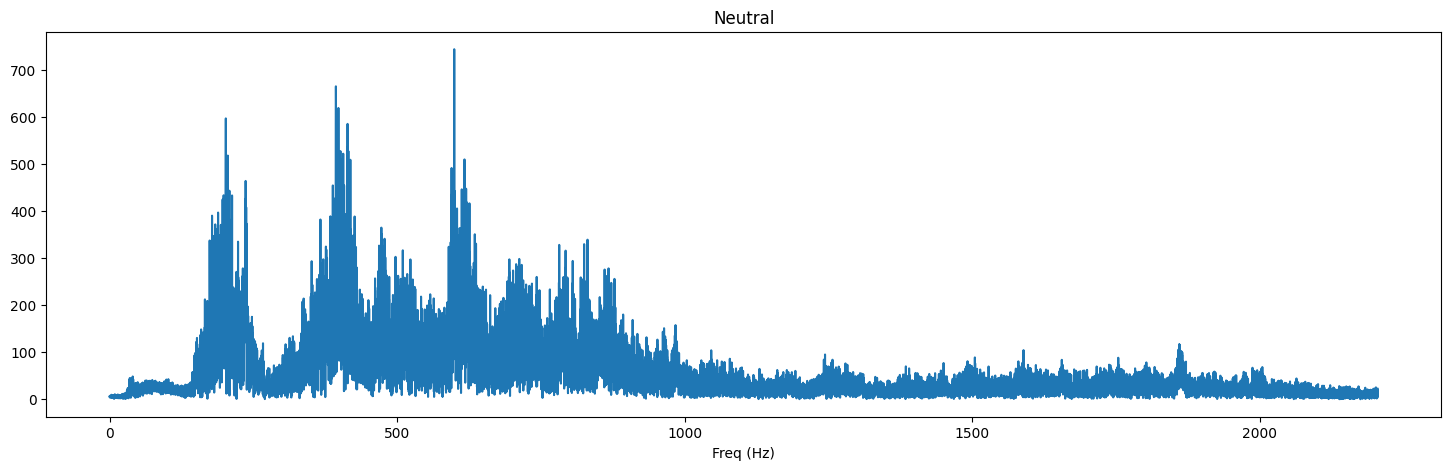

In [46]:
plot_mag_spec(neu_lw,"Neutral", sr, 0.1)

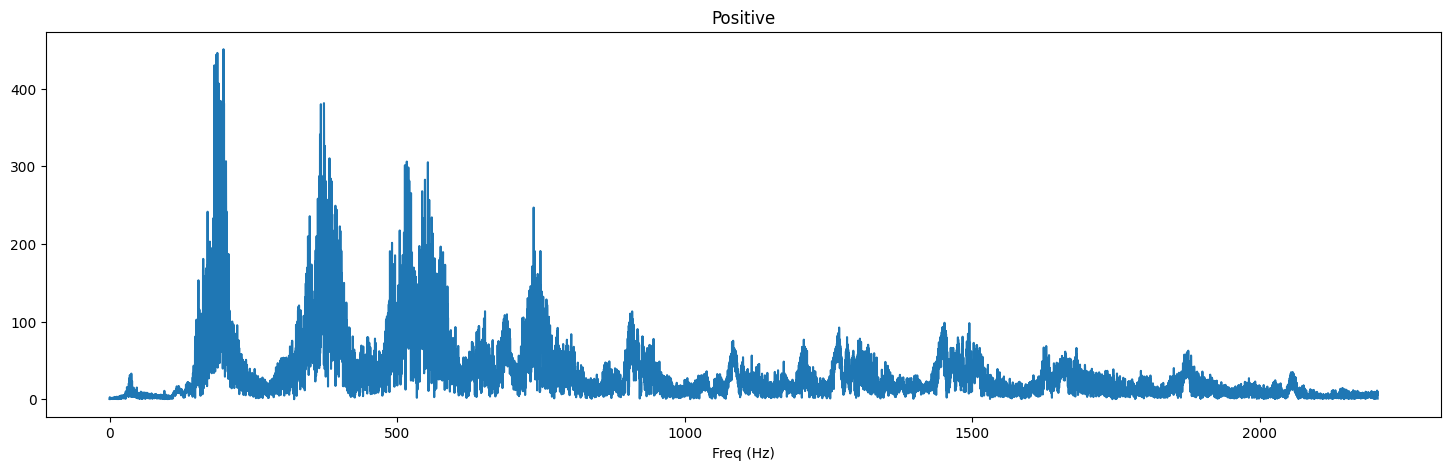

In [47]:
plot_mag_spec(pos_lw,"Positive", sr, 0.1)

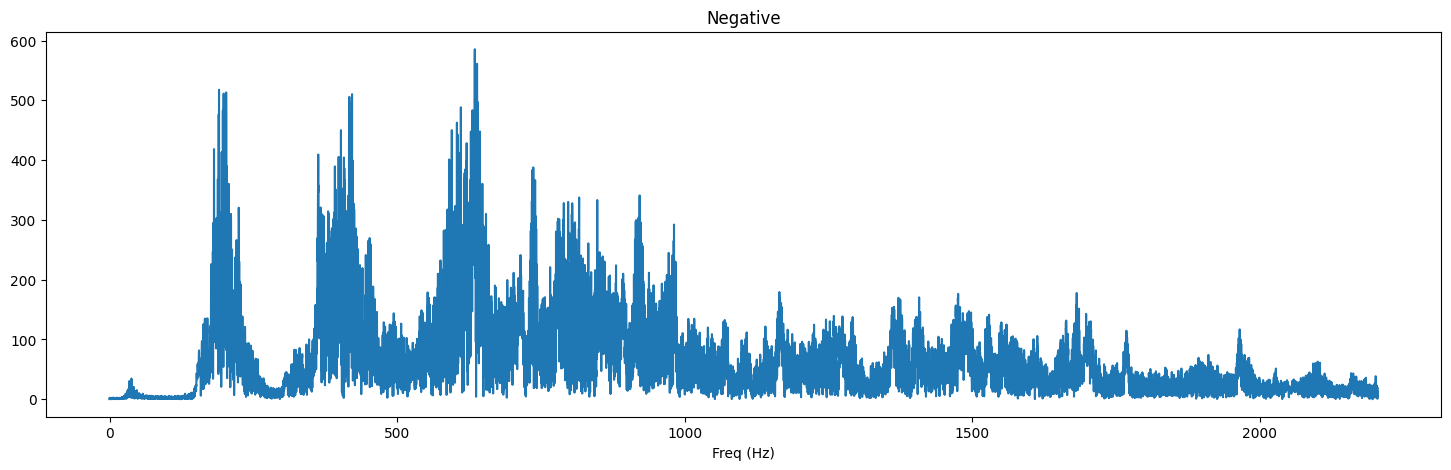

In [48]:
plot_mag_spec(neg_lw,"Negative", sr, 0.1)

In [49]:
#Method 2
from __future__ import print_function
import scipy.io.wavfile as wavfile
import scipy
import scipy.fftpack
from scipy.signal import argrelextrema
import numpy as np
from matplotlib import pyplot as plt

In [50]:
time_period = 0.1 # FFT time period (in seconds). Can comfortably process time frames from 0.05 seconds - 10 seconds
fs_rate, signal_original = wavfile.read(neu_dir)
total_time = int(np.floor(len(signal_original)/fs_rate))
sample_range = np.arange(0,total_time,time_period)
total_samples = len(sample_range)

print ("Frequency sampling", fs_rate)
print ("total time: ", total_time)
print ("sample time period: ", time_period)
print ("total samples: ", total_samples)

Frequency sampling 16000
total time:  8
sample time period:  0.1
total samples:  80


In [51]:
output_array = []
for i in sample_range:
    #print ("Processing: %d / %d (%d%%)" % (i/time_period + 1, total_samples, (i/time_period + 1)*100/total_samples))
    sample_start = int(i*fs_rate)
    sample_end = int((i+time_period)*fs_rate)
    signal = signal_original[sample_start:sample_end]

    l_audio = len(signal.shape)
    #print ("Channels", l_audio)

    if l_audio == 2:
        signal = signal.sum(axis=1) / 2
    N = signal.shape[0]
    #print ("Complete Samplings N", N)

    secs = N / float(fs_rate)
    # print ("secs", secs)
    Ts = 1.0/fs_rate # sampling interval in time
    #print ("Timestep between samples Ts", Ts)

    t = np.arange(0, secs, Ts) # time vector as scipy arange field / numpy.ndarray

    FFT = abs(scipy.fft.fft(signal))
    FFT_side = FFT[range(int(N/2))] # one side FFT range
    freqs = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])
    fft_freqs = np.array(freqs)
    freqs_side = freqs[range(int(N/2))] # one side frequency range
    fft_freqs_side = np.array(freqs_side)

    # Reduce to 0-5000 Hz
    bucket_size = 5
    buckets = 16

    FFT_side = FFT_side[0:bucket_size*buckets]
    fft_freqs_side = fft_freqs_side[0:bucket_size*buckets]

    # Combine frequencies into buckets
    FFT_side = np.array([int(sum(FFT_side[current: current+bucket_size])) for current in range(0, len(FFT_side), bucket_size)])
    fft_freqs_side = np.array([int(sum(fft_freqs_side[current: current+bucket_size])) for current in range(0, len(fft_freqs_side), bucket_size)])

    # FFT_side: Normalize (0-1)
    max_value = max(FFT_side)
    if (max_value != 0):
        FFT_side_norm = FFT_side / max_value

    # Append to output array
    output_array.append(FFT_side_norm)


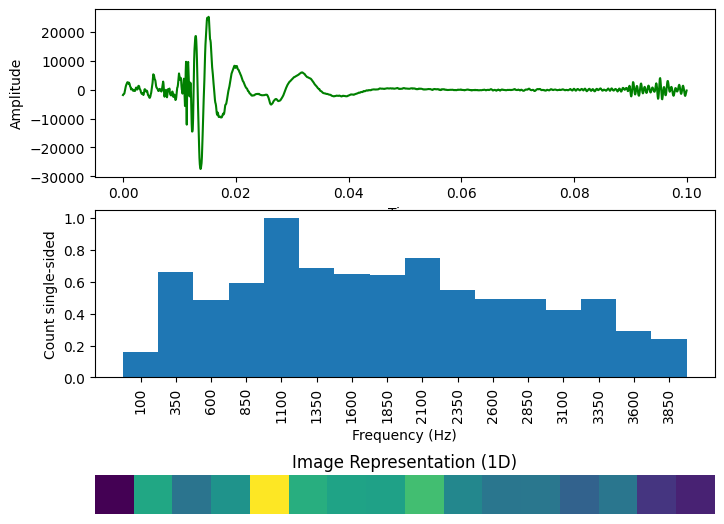

In [52]:
# Plotting

plt.figure(figsize=(8,10))
plt.subplot(411)
plt.plot(t, signal, "g") # plotting the signal
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(412)
diff = np.diff(fft_freqs_side)
widths = np.hstack([diff, diff[-1]])
plt.bar(fft_freqs_side, abs(FFT_side_norm), width=widths) # plotting the positive fft spectrum
plt.xticks(fft_freqs_side, fft_freqs_side, rotation='vertical')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count single-sided')

FFT_side_norm_line = FFT_side_norm.copy()
FFT_side_norm_line.resize( (1,buckets) )

plt.subplot(413)
plt.imshow(FFT_side_norm_line)
plt.axis('off')
plt.title('Image Representation (1D)')

plt.show()